Feature: Search Grid Search
===========================

A classic method to perform model-fitting is a grid search, where the parameters of a model are divided on to a grid of
values and the likelihood of each set of parameters on this grid is sampled. For low dimensionality problems this
simple approach can be sufficient to locate high likelihood solutions, however it scales poorly to higher dimensional
problems.

**PyAutoFit** can perform a search grid search, which allows one to perform a grid-search over a subset of parameters
within a model, but use a non-linear search to fit for the other parameters. The parameters over which the grid-search
is performed are also included in the model fit and their values are simply confined to the boundaries of their grid
cell by setting these as the lower and upper limits of a `UniformPrior`.

The benefits of using a search grid search are:

 - For problems with complex and multi-model parameters spaces it can be difficult to robustly and efficiently perform
 model-fitting. If specific parameters are known to drive the multi-modality then sampling over a grid can ensure the
 parameter space of each individual model-fit is not multi-modal and therefore sampled more accurately and efficiently.

 - It can provide a goodness-of-fit measure (e.g. the Bayesian evidence) of many model-fits over the grid. This can
 provide additional insight into where the model does and does not fit the data well, in a way that a standard
 non-linear search does not.

 - The search grid search is embarrassingly parallel, and if sufficient computing facilities are available one can
 perform model-fitting faster in real-time than a single non-linear search. The **PyAutoFit** search grid search
 includes an option for parallel model-fitting via the Python `multiprocessing` module.

In this example we will demonstrate the search grid search feature, again using the example of fitting 1D Gaussian's
in noisy data.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autofit as af
import model as m
import analysis as a

import matplotlib.pyplot as plt
import numpy as np
from os import path

/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace`


__Data__

First, lets load data of a 1D Gaussian, by loading it from a .json file in the directory 
`autofit_workspace/dataset/gaussian_x1_with_feature`.

This 1D data includes a small feature to the right of the central `Gaussian`. This feature is a second `Gaussian` 
centred on pixel 70. 

In [2]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1_with_feature")
data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

Now lets plot the data, including its error bars. 

The feature on pixel 70 is clearly visible.

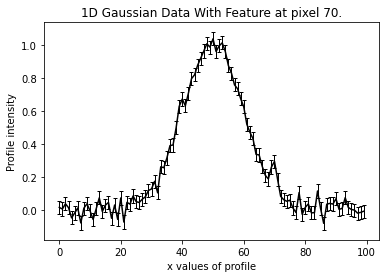

In [3]:
xvalues = range(data.shape[0])

plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.title("1D Gaussian Data With Feature at pixel 70.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

__Model__

Next, we create the model, which in this case corresponds to two `Gaussian`'s, one for the main signal seen in the
data and one for the feature on pixel 70.

In [4]:
model = af.CollectionPriorModel(gaussian_main=m.Gaussian, gaussian_feature=m.Gaussian)

__Analysis__

Our Analysis class is described in `analysis.py` and is the same used in the `overview/complex` example. 

It fits the data as the sum of the two `Gaussian`'s in the model.

In [5]:
analysis = a.Analysis(data=data, noise_map=noise_map)

__Search__

We will now fit the data using a single non-linear search, to demonstrate the behaviour of the fit before we invoke
the search grid search.

In [6]:
dynesty = af.DynestyStatic(
    name="single_fit",
    path_prefix=path.join("features", "search_grid_search"),
    n_live_points=100,
    iterations_per_update=500,
    maxcall=30000,
)

To perform the fit with Dynesty, we pass it our model and analysis and we`re good to go!

Checkout the folder `autofit_workspace/output/features.search_grid_search/single_fit`, where the `NonLinearSearch` 
results, visualization and information can be found.

For test runs on my laptop it is 'hit or miss' whether the feature is fitted correctly. This is because although models
including the feature corresponds to the highest likelihood solutions, they occupy a small volume in parameter space
which the non linear search may miss. Furthemore, it is common for the model-fit to get stuck in local maxima where
both `Gaussian`'s go to a centre value of 50.0.

The fit can also take a very long time to run, therefore I limited `Dynesty` to 30000 iterations above.

In [7]:
result = dynesty.fit(model=model, analysis=analysis)

INFO:root:single_fit already completed, skipping non-linear search.


__Result__

If you ran the fit above, you can now plot the result. 

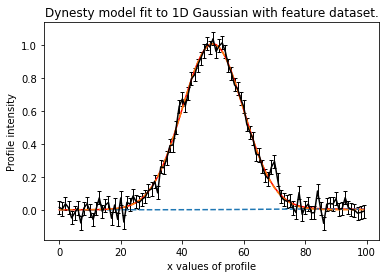

In [8]:
instance = result.max_log_likelihood_instance

gaussian_main = instance.gaussian_main.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
gaussian_feature = instance.gaussian_feature.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
model_data = gaussian_main + gaussian_feature

plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(range(data.shape[0]), model_data, color="r")
plt.plot(range(data.shape[0]), gaussian_main, "--")
plt.plot(range(data.shape[0]), gaussian_feature, "--")
plt.title("Dynesty model fit to 1D Gaussian with feature dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

__Search Grid Search__

We will now perform the search grid search. 

We will use the same `Dynesty` settings, but change its `name`.

In [9]:
dynesty = af.DynestyStatic(
    name="grid_fit",
    path_prefix=path.join("features", "search_grid_search"),
    n_live_points=100,
    iterations_per_update=500,
    maxcall=30000,
)

To set up the search grid search we specify two additional settings:

`number_of_steps`: The number of steps in the grid search that are performedm which is set to 5 below. 
 
Because the prior on the parameter `centre` is a `UniformPrior` from 0.0 -> 100.0, this means the first grid search
will set the prior on the centre to be a `UniformPrior` from 0.0 -> 20.0. The second will run from 20.0 -> 40.0,
the third 40.0 -> 60.0, and so on.
   
`parallel`: If `True`, each grid search is performed in parallel on your laptop. 

`number_of_cores`: The number of cores the grid search will parallelize the run over. If `number_of_cores=1`, the
search is run in serial. For > 1 core, 1 core is reserved as a farmer, e.g., if `number_of_cores=4` then up to 3 
searches will be run in parallel. In case your laptop has limited hardware resources we do not run in parallel in 
this example by default, but feel free to change the option to `True` if you have a lot of CPUs and memory!

In [10]:
grid_search = af.SearchGridSearch(search=dynesty, number_of_steps=5, number_of_cores=1)

We can now run the grid search.

This is where we specify the parameter over which the grid search is performed, in this case the `centre` of the 
`gaussian_feature` in our model.

On my laptop, each model fit performed by the grid search takes ~15000 iterations, whereas the fit above
required ~ 40000 iterations. Thus, in this simple example, the grid search did not speed up the overall analysis 
(unless it is run in parallel). However, more complex and realistic model-fitting problems, the grid search has the
potential to give huge performance improvements if used effectively.

In [11]:
grid_search_result = grid_search.fit(
    model=model, analysis=analysis, grid_priors=[model.gaussian_feature.centre]
)

INFO:root:grid_fit/dynesty_static[nlive_100__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/gaussian_feature_centre_0.00_20.00 already completed, skipping non-linear search.
INFO:root:grid_fit/dynesty_static[nlive_100__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/gaussian_feature_centre_20.00_40.00 already completed, skipping non-linear search.
INFO:root:grid_fit/dynesty_static[nlive_100__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/gaussian_feature_centre_40.00_60.00 already completed, skipping non-linear search.
INFO:root:grid_fit/dynesty_static[nlive_100__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/gaussian_feature_centre_60.00_80.00 already completed, skipping non-linear search.
INFO:root:grid_fit/dynesty_static[nlive_100__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/gaussian_feature_centre_80.00_100.00 already completed, skipping non-linear search.


This returns a `GridSearchResult`, which includes information on every model-fit performed on the grid.

Below, we print:
 
 - The central value of the `UniformPrior` on the `centre` of the gaussian_feature` for each fit performed on the
 grid search. 
 
 - The maximum log likelihood value of each of the 5 fits. 
 
 - The Bayesian evidence of each (this is accessible because we used a nested sampling algorithm).

You should see that the highest likelihood and evidence values correspond to run 4, where the `UniformPrior` on the
centre parameter ran from 60 -> 80 and therefore captured the true value of 70.0.

In [12]:
print(grid_search_result.physical_centres_lists)
print(grid_search_result.max_log_likelihood_values)
print(grid_search_result.log_evidence_values)

[[10.000000000000004], [30.000000000000004], [50.0], [70.00000000000001], [90.0]]
[-53.247361   -53.1049094  -40.80457287 -40.92801451 -51.65045258]
[-70.91906204 -70.7684405  -67.59167606 -67.92054919 -70.64174455]


We can also access the `best_result` and `best_model`.

In [13]:
print(grid_search_result.best_result)
print(grid_search_result.best_model)
print(grid_search_result.best_model.gaussian_main.centre)
print(grid_search_result.best_model.gaussian_main.intensity)
print(grid_search_result.best_model.gaussian_main.sigma)
print(grid_search_result.best_model.gaussian_feature.centre)
print(grid_search_result.best_model.gaussian_feature.intensity)
print(grid_search_result.best_model.gaussian_feature.sigma)

Analysis Result:
samples: <autofit.non_linear.samples.NestSamples object at 0x7fc84f0dc250>
previous_model: Gaussian (centre, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (intensity, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (sigma, UniformPrior, lower_limit = 0.0, upper_limit = 25.0), Gaussian (centre, UniformPrior, lower_limit = 40.0, upper_limit = 60.00000000000001), (intensity, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (sigma, UniformPrior, lower_limit = 0.0, upper_limit = 25.0)
search: <autofit.non_linear.nest.dynesty.DynestyStatic object at 0x7fc84f0dc520>
_Result__model: None
_instance: <autofit.mapper.model.ModelInstance object at 0x7fc84f0dc910>
Gaussian (centre, GaussianPrior, mean = 69.75882047187383, sigma = 68.64901602400867), (intensity, GaussianPrior, mean = 0.1730082159721804, sigma = 1.3504241146009384), (sigma, GaussianPrior, mean = 5.880710879880471, sigma = 18.867438534909628), Gaussian (centre, GaussianPrior, me

By plotting the `best_model` we can confirm the grid search fitted the feature at pixel 70.

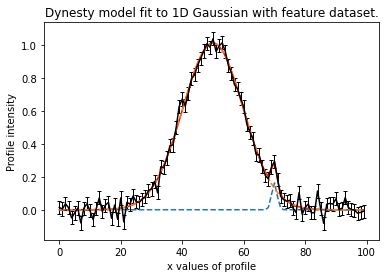

In [14]:
instance = grid_search_result.best_result.instance

gaussian_main = instance.gaussian_main.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
gaussian_feature = instance.gaussian_feature.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
model_data = gaussian_main + gaussian_feature

plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(range(data.shape[0]), model_data, color="r")
plt.plot(range(data.shape[0]), gaussian_main, "--")
plt.plot(range(data.shape[0]), gaussian_feature, "--")
plt.title("Dynesty model fit to 1D Gaussian with feature dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

A multi-dimensional grid search can be easily performed by adding more parameters to the `grid_priors` input.

The fit below belows performs a 5x5 grid search over the `centres` of both `Gaussians`. This would take quite a long
time to run, so I've commented it out, but feel free to run it!

In [15]:
# grid_search_result = grid_search.fit(
#     model=model,
#     analysis=analysis,
#     grid_priors=[model.gaussian_feature.centre, model.gaussian_main.centre],
# )

Finish.